<a href="https://colab.research.google.com/github/FahadahmedK/Dynamic-DeepHit/blob/master/DDH_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/FahadahmedK/Dynamic-DeepHit #clone github modules 

Cloning into 'Dynamic-DeepHit'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 9), reused 17 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
!pip install lifelines

%tensorflow_version 1.x

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

os.chdir('/content/Dynamic-DeepHit')


import tensorflow as tf
import random


from sklearn.model_selection import train_test_split
from class_DeepLongitudinal import Model_Longitudinal_Attention
from utils_eval import c_index, brier_score
from utils_log import save_logging, load_logging
from utils_helper import f_get_minibatch, f_get_boosted_trainset

### **Preparing dataset**

In [ ]:
data = pd.read_csv('dcr.csv') #reading the dcr dataset from http://www.internationalfinancialresearch.org/

#sorting values by id and time
df = data.sort_values(by = ['id', 'time'])

In [ ]:
#renumbering id values 

id_list = []
for i,_ in enumerate(pd.Series(df['id']).unique()):
    for x in range(sum(df['id'] == _)):
        id_list.append(i+1)

df['id_new'] = id_list

In [ ]:
#constructing time-to-event variable

df.rename(columns = {'time': 'times'}, inplace = True)


df['tte'] = df.groupby('id')['times'].transform(max)
df['tte'] = df['tte']+1

In [ ]:
df.isnull().sum() #none of the variables we use have missing values with the exception of LTV_time

id                             0
times                          0
orig_time                      0
first_time                     0
mat_time                       0
res_time                   61018
balance_time                   0
LTV_time                      25
interest_rate_time             0
rate_time                      0
hpi_time                       0
gdp_time                       0
uer_time                       0
REtype_CO_orig_time            0
REtype_PU_orig_time            0
REtype_SF_orig_time            0
investor_orig_time             0
balance_orig_time              0
FICO_orig_time                 0
LTV_orig_time                  0
Interest_Rate_orig_time        0
state_orig_time              350
hpi_orig_time                  0
default_time                   0
payoff_time                    0
status_time                    0
lgd_time                   60653
recovery_res               60653
id_new                         0
tte                            0
dtype: int

In [ ]:
df = df.drop(['id'], axis = 1)

df.rename(columns = {'id_new' : 'id', 'status_time' : 'label'}, inplace = True)

df['label'].value_counts()

0    58028
2     2625
1     1525
Name: label, dtype: int64

In [ ]:
#taking averages of TVC's for each subject

cols_for_avg = ['balance_time', 'interest_rate_time', 'LTV_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time']

for i in cols_for_avg:
    
    df['avg_'+i] = df.groupby('id')[i].transform(np.mean)

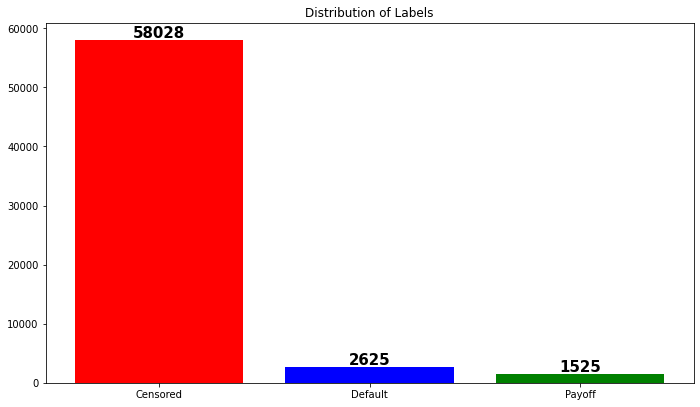

In [ ]:
#distribution of labels

counts_label = df['label'].value_counts()

fig = plt.figure(figsize=(9,5))
axes = fig.add_axes([0,0,1,1])
categ = ['Censored', 'Default', 'Payoff']
labels = [counts_label[0], counts_label[2], counts_label[1]]
axes.bar(categ, labels , color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
for i in range(len(categ)):
    plt.text(i, labels[i]+400, labels[i], ha = 'center', fontweight = 'bold', fontsize = 15)
plt.show()

In [ ]:
cols = ['id', 'tte', 'times','label',
       'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time',
       'hpi_time', 'gdp_time', 'uer_time','avg_balance_time', 'avg_interest_rate_time',
       'avg_LTV_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time',
       'avg_uer_time','FICO_orig_time', 'REtype_CO_orig_time',
       'REtype_PU_orig_time', 'REtype_SF_orig_time']

df1 = df[cols]

df1.to_csv('dcr_cleaned.csv')


In [ ]:

#df2 = df1.copy()
#df3 = pd.DataFrame()
#for i in range(len(df2.id.unique())):
#  df3= df3.append(df2[df2['id'] == i+1].drop(df2[df2['id'] == i+1].tail(1).index))

#df3.reset_index(drop = True, inplace=True)
#df3.to_csv('dcr_cleaned.csv', index = False)

In [ ]:
pd.read_csv('dcr_cleaned.csv').head()

,Unnamed: 0,id,tte,times,label,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,avg_balance_time,avg_interest_rate_time,avg_LTV_time,avg_rate_time,avg_hpi_time,avg_gdp_time,avg_uer_time,FICO_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time
0,0,1,61,25,0,61031.10,33.911009,10.500,5.9,226.29,2.899137,4.7,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1
1,1,1,61,26,0,60882.42,34.007232,10.500,5.9,225.10,2.151365,4.7,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1
2,2,1,61,27,0,60729.80,34.335349,10.500,5.9,222.39,2.361722,4.4,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1
3,3,1,61,28,0,60576.14,34.672545,10.875,5.9,219.67,1.229172,4.6,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1
4,4,1,61,29,0,60424.39,34.951639,10.875,5.9,217.37,1.692969,4.5,57546.403143,10.107143,41.626867,5.9,176.642286,1.264322,7.162857,587,0,0,1


**Defining functions to ready the dataset for Dynamic DeepHit**

In [ ]:
##### USER-DEFINED FUNCTIONS
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset( data, bin_list, cont_list, norm_mode = 'standard'):

    df_                = pd.read_csv(data)

    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

**Prediction Functions for DDH**

In [ ]:
def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

# **Model 1**

-Model 1 uses all the variables in the dataset

### **Import dataset** 

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'FICO_orig_time', 'uer_time', 'gdp_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

### **Setting Hyperparameters**

In [ ]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32,

             'iteration_burn_in': 1000,
             'iteration': 5000,

             'keep_prob': 0.6,
             'lr_train': 1e-4,

             'h_dim_RNN': 100,
             'h_dim_FC' : 100,
             'num_layers_RNN':2,
             'num_layers_ATT':2,
             'num_layers_CS' :2,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :1.0,
             'beta'  :0.1,
             'gamma' :1.0
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)

**Defining training, validation and test sets**

In [ ]:
### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

**Train DDH**

In [ ]:
_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))

INFO:tensorflow:Scale of 0 disables regularizer.
BURN-IN TRAINING ...
itr: 1000 | loss: 4.1906
MAIN TRAINING ...
itr: 1000 | loss: 3.0458
updated.... average c-index = 0.7306
itr: 2000 | loss: 2.1038
updated.... average c-index = 0.7316
itr: 3000 | loss: 2.0542
updated.... average c-index = 0.7367
itr: 4000 | loss: 2.4076
updated.... average c-index = 0.7393
itr: 5000 | loss: 2.3560
updated.... average c-index = 0.7402


### **Test DDH**

In [ ]:

saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

INFO:tensorflow:Restoring parameters from DCR/model
--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 3  eval_time 5  eval_time 10
pred_time 12: event_1     0.990973     0.990973     0.990973      0.987027
pred_time 12: event_2     0.947948     0.947948     0.962064      0.981735
pred_time 20: event_1     0.993063     0.987027     0.986057      0.985811
pred_time 20: event_2     0.979865     0.981766     0.981439      0.982796
pred_time 30: event_1     0.987057     0.986903     0.987439      0.987439
pred_time 30: event_2     0.983094     0.983349     0.983349      0.983326
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 1  eval_time 3  eval_time 5  eval_time 10
pred_time 12: event_1     0.000144     0.000162     0.000225      0.000946
pred_time 12: event_2     0.000910     0.001024     0.001416      0.005762
pred_time 20: event_1     0.000710     0.001243     0.00

In [ ]:
print(np.mean(df1.iloc[[1, 3, 5],], axis = 0))
print(np.mean(df1.iloc[[0, 2, 4],], axis = 0))

eval_time 1     0.978774
eval_time 3     0.978973
eval_time 5     0.979110
eval_time 10    0.978002
dtype: float64
eval_time 1     0.990983
eval_time 3     0.989139
eval_time 5     0.989293
eval_time 10    0.988451
dtype: float64


# **Model 2**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['avg_balance_time', 'avg_LTV_time', 'avg_interest_rate_time', 'avg_rate_time', 'avg_hpi_time', 'avg_gdp_time', 'avg_uer_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [12, 18, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)


burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






BURN-IN TRAINING ...
itr: 1000 | loss: 4.5475
MAIN TRAINING ...
itr: 1000 | loss: 1.9816
updated.... average c-index = 0.7194
it

In [ ]:
print(np.mean(df1.iloc[[1, 3, 5],], axis = 0))
print(np.mean(df1.iloc[[0, 2, 4],], axis = 0))

eval_time 1     0.978774
eval_time 3     0.978973
eval_time 5     0.979110
eval_time 10    0.978002
dtype: float64
eval_time 1     0.990983
eval_time 3     0.989139
eval_time 5     0.989293
eval_time 10    0.988451
dtype: float64


## **Model 3**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [9, 20, 30] # prediction time (in months)
    eval_time = [1, 3, 5, 10] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

INFO:tensorflow:Scale of 0 disables regularizer.
BURN-IN TRAINING ...
itr: 1000 | loss: 2.5381
MAIN TRAINING ...
itr: 1000 | loss: 1.2842
updated.... average c-index = 0.5588
itr: 2000 | loss: 1.2023
updated.... average c-index = 0.5598
itr: 3000 | loss: 0.9128
updated.... average c-index = 0.5633
itr: 4000 | loss: 1.1996
updated.... average c-index = 0.5650
itr: 5000 | loss: 1.3413
INFO:tensorflow:Restoring parameters from DCR/model
--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 3  eval_time 5  eval_time 10
pred_time 9: event_1      0.949850     0.949850     0.949850      0.949541
pred_time 9: event_2      0.969970     0.969970     0.969970      0.974240
pred_time 20: event_1     0.953521     0.957903     0.962092      0.968750
pred_time 20: event_2     0.974254     0.980127     0.980706      0.984285
pred_time 30: event_1     0.970108     0.970108     0.971123      0.971123
pred_time 30: event_2     0.984284     0.98

In [ ]:
print(np.mean(df1.iloc[[1, 3, 5],], axis = 0))
print(np.mean(df1.iloc[[0, 2, 4],], axis = 0))

eval_time 1     0.976169
eval_time 3     0.978191
eval_time 5     0.978377
eval_time 10    0.981001
dtype: float64
eval_time 1     0.957826
eval_time 3     0.959287
eval_time 5     0.961021
eval_time 10    0.963138
dtype: float64


# **Model 4**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'avg_interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [9, 18, 30] # prediction time (in months)
    eval_time = [6, 9, 15, 30] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

# **Model 5**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'avg_rate_time', 'hpi_time', 'gdp_time', 'uer_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [9, 18, 30] # prediction time (in months)
    eval_time = [6, 9, 15, 30] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

# **Model 6**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'avg_rate_time', 'avg_hpi_time', 'gdp_time', 'uer_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [9, 18, 30] # prediction time (in months)
    eval_time = [6, 9, 15, 30] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

**Model 7**

In [ ]:

data_mode                   = 'DCR' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'DCR':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard', data = 'dcr_cleaned.csv', bin_list = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'],
                                                                                                                cont_list = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'avg_gdp_time', 'uer_time'])
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [9, 18, 30] # prediction time (in months)
    eval_time = [6, 9, 15, 30] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32, 'iteration_burn_in': 1000, 'iteration': 5000, 'keep_prob': 0.6, 'lr_train': 1e-4,'h_dim_RNN': 100, 'h_dim_FC' : 100, 'num_layers_RNN':2,'num_layers_ATT':2,'num_layers_CS' :2,
              'RNN_type':'LSTM', 'FC_active_fn' : tf.nn.relu, 'RNN_active_fn': tf.nn.tanh, 'reg_W': 1e-5, 'reg_W_out'     : 0., 'alpha' :1.0, 'beta'  :0.1,'gamma' :1.0}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim': x_dim, 'x_dim_cont'    : x_dim_cont, 'x_dim_bin'     : x_dim_bin, 'num_Event'     : num_Event, 'num_Category'  : num_Category,  'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'], 'h_dim_FC': new_parser['h_dim_FC'], 'num_layers_RNN'    : new_parser['num_layers_RNN'], 'num_layers_ATT'    : new_parser['num_layers_ATT'],
'num_layers_CS'     : new_parser['num_layers_CS'],
'RNN_type'          : new_parser['RNN_type'], 'FC_active_fn'      : new_parser['FC_active_fn'], 'RNN_active_fn'     : new_parser['RNN_active_fn'],
'initial_W'         : tf.contrib.layers.xavier_initializer(), 'reg_W'             : new_parser['reg_W'], 'reg_W_out'         : new_parser['reg_W_out']}


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)


### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)



_EPSILON = 1e-08

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))



saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,t+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')